In [4]:
# this note book is about SVM model training and evaluation
# very similar structure as the random forest notebook
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
import time
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [5]:
# set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# record start time
total_start_time = time.time()

#1 load the data 

print(" Loading datasets...")
loading_start_time = time.time()

train_metadata = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/train_metadata.csv")
print(f" Loaded metadata: {train_metadata.shape}")

print("   Loading provided features...")
color_hist = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/Features/color_histogram.csv")
hog_pca = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/Features/hog_pca.csv")
additional_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/Features/additional_features.csv")

print("   Loading new feature sets...")
new_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/new_features.csv")
deep_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/deep_features.csv")

loading_time = time.time() - loading_start_time
print(f" All datasets loaded in {loading_time:.1f}s")

print(f"   Color histogram: {color_hist.shape}")
print(f"   HOG PCA: {hog_pca.shape}")
print(f"   Additional features: {additional_features.shape}")
print(f"   New features: {new_features.shape}")
print(f"   Deep features: {deep_features.shape}")


# create the feature combinations
print("\n Creating feature combinations...")
combination_start_time = time.time()

# merge provided features
print("   Combining provided features...")
provided_features = color_hist.merge(hog_pca, on='image_path')
provided_features = provided_features.merge(additional_features, on='image_path')
print(f"    Provided features combined: {provided_features.shape}")

# create 4 feature sets
feature_sets = {}

print("   Creating feature set combinations...")
# 1. provided features only
feature_sets['Provided Features'] = provided_features.copy()

# 2. new features only
feature_sets['New Features'] = new_features.copy()

# 3. deep features only
feature_sets['Deep Features'] = deep_features.copy()

# 4. combined (Provided + New)
print("   Merging provided and new features...")
combined_features = provided_features.merge(new_features, on='image_path')
feature_sets['Combined (Provided + New)'] = combined_features.copy()

# add labels to each feature set
print("   Adding labels to feature sets...")
for name, features_df in tqdm(feature_sets.items(), desc="   Processing feature sets"):
    # merge with metadata to get labels
    features_with_labels = features_df.merge(train_metadata[['image_path', 'ClassId']], on='image_path')
    feature_sets[name] = features_with_labels
    
    print(f"    {name}: {features_with_labels.shape} (features + label)")

combination_time = time.time() - combination_start_time
print(f" Feature combinations completed in {combination_time:.1f}s")

 Loading datasets...
 Loaded metadata: (5488, 5)
   Loading provided features...
   Loading new feature sets...
 All datasets loaded in 0.7s
   Color histogram: (5488, 97)
   HOG PCA: (5488, 21)
   Additional features: (5488, 5)
   New features: (5488, 57)
   Deep features: (5488, 2049)

 Creating feature combinations...
   Combining provided features...
    Provided features combined: (5488, 121)
   Creating feature set combinations...
   Merging provided and new features...
   Adding labels to feature sets...


   Processing feature sets: 100%|████████████████| 4/4 [00:00<00:00, 297.40it/s]

    Provided Features: (5488, 122) (features + label)
    New Features: (5488, 58) (features + label)
    Deep Features: (5488, 2050) (features + label)
    Combined (Provided + New): (5488, 178) (features + label)
 Feature combinations completed in 0.0s


In [7]:
# set up cross-validation
# Stratified K-Fold setup
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# results storage
cv_results = defaultdict(list)
feature_importance_results = {}

# do the hyperparameter tuning and evaluation

def tune_svm_hyperparameters(X, y, cv_folds, quick_tune=True):
    """
    find best hyperparameters for SVM
    """
    print(" Tuning SVM hyperparameters...")
    tune_start_time = time.time()
    
    # define parameter grid
    if quick_tune:
        # quick tuning for time constraints
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto', 0.001, 0.01]
        }
        total_combinations = len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma'])
        
        print(f"   Testing {total_combinations} parameter combinations...")
        
        search = GridSearchCV(
            SVC(class_weight='balanced', random_state=RANDOM_SEED),
            param_grid, cv=cv_folds, scoring='accuracy', n_jobs=-1, verbose=0
        )
    else:
        # more comprehensive tuning
        param_dist = {
            'C': [0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1],
            'degree': [2, 3, 4]  # Only used for poly kernel
        }
        print(f"   Testing 25 random parameter combinations...")
        
        search = RandomizedSearchCV(
            SVC(class_weight='balanced', random_state=RANDOM_SEED),
            param_dist, n_iter=25, cv=cv_folds, scoring='accuracy', 
            random_state=RANDOM_SEED, n_jobs=-1, verbose=0
        )
    
    # standardize features for hyperparameter tuning (CRITICAL for SVM)
    print("   Standardizing features for tuning...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # perform search with progress
    print("   Running SVM hyperparameter search...")
    search.fit(X_scaled, y)
    
    tune_time = time.time() - tune_start_time
    print(f"   SVM hyperparameter tuning completed in {tune_time:.1f}s")
    print(f"     Best parameters: {search.best_params_}")
    print(f"     Best CV score: {search.best_score_:.4f}")
    
    return search.best_params_, search.best_score_

def evaluate_svm_feature_set(feature_set_name, features_df):
    """
    evaluate a feature set using stratified cross-validation with SVM hyperparameter tuning
    """
    print(f"\n Training SVM on {feature_set_name}")
    print("-" * 50)
    
    eval_start_time = time.time()
    
    # prepare data
    X = features_df.drop(['image_path', 'ClassId'], axis=1)
    y = features_df['ClassId'].values
    
    print(f"Feature matrix: {X.shape}")
    print(f"Number of classes: {len(np.unique(y))}")
    
    # tune hyperparameters (using inner CV)
    best_params, best_cv_score = tune_svm_hyperparameters(X, y, 3, quick_tune=True)
    
    # store results for this feature set
    fold_accuracies = []
    fold_reports = []
    all_y_true = []
    all_y_pred = []
    all_val_indices = []
    
    # perform stratified cross-validation with best parameters
    print(f"\n    Running {N_FOLDS}-fold cross-validation...")
    
    cv_folds = list(skf.split(X, y))
    for fold, (train_idx, val_idx) in enumerate(tqdm(cv_folds, desc="   CV Folds", leave=False)):
        fold_start_time = time.time()
        
        # split data according to CV folds (IMPORTANT: no data leakage)
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y[train_idx]
        y_val_fold = y[val_idx]
        
        # standardize features (fit on train, transform both)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # train SVM with best parameters
        svm = SVC(
            class_weight='balanced',
            random_state=RANDOM_SEED,
            **best_params  # Use tuned hyperparameters
        )
        
        svm.fit(X_train_scaled, y_train_fold)
        
        # predict on validation fold
        y_pred = svm.predict(X_val_scaled)
        
        # calculate accuracy
        fold_accuracy = accuracy_score(y_val_fold, y_pred)
        fold_accuracies.append(fold_accuracy)
        
        # store classification report
        report = classification_report(y_val_fold, y_pred, output_dict=True, zero_division=0)
        fold_reports.append(report)
        
        # store predictions for detailed analysis
        all_y_true.extend(y_val_fold)
        all_y_pred.extend(y_pred)
        all_val_indices.extend(val_idx)
        
        fold_time = time.time() - fold_start_time
        tqdm.write(f"      Fold {fold + 1}/{N_FOLDS}: Accuracy={fold_accuracy:.4f}, Time={fold_time:.1f}s")
    
    # calculate average results
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    
    # store results (Note: SVM doesn't have feature importance like RF)
    cv_results[feature_set_name] = {
        'fold_accuracies': fold_accuracies,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'fold_reports': fold_reports,
        'best_params': best_params,
        'best_cv_score': best_cv_score,
        'all_y_true': all_y_true,
        'all_y_pred': all_y_pred,
        'val_indices': all_val_indices
    }
    
    # store feature info (no importance for SVM, but keep structure consistent)
    feature_importance_results[feature_set_name] = {
        'feature_names': X.columns.tolist(),
        'n_features': len(X.columns)
    }
    
    eval_time = time.time() - eval_start_time
    print(f"   {feature_set_name} completed in {eval_time:.1f}s")
    print(f"     Average Accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")
    
    return mean_accuracy, std_accuracy

In [10]:
# train all feature sets
print("\n Training SVM models on all feature sets...")
print("=" * 60)

training_start_time = time.time()

# train and evaluate each feature set with progress tracking
feature_set_names = list(feature_sets.keys())
print(f"Training {len(feature_set_names)} different feature sets...")

overall_progress = tqdm(feature_set_names, desc=" Overall Progress", position=0)

for i, feature_set_name in enumerate(overall_progress):
    features_df = feature_sets[feature_set_name]
    
    # update progress bar description
    overall_progress.set_description(f" Training {i+1}/{len(feature_set_names)}: {feature_set_name}")
    
    # evaluate this feature set
    mean_acc, std_acc = evaluate_svm_feature_set(feature_set_name, features_df)
    
    # update progress bar with current results
    overall_progress.set_postfix({
        'Accuracy': f'{mean_acc:.3f}±{std_acc:.3f}',
        'Best_so_far': f'{max([cv_results[name]["mean_accuracy"] for name in cv_results.keys()]):.3f}'
    })

overall_progress.close()

training_time = time.time() - training_start_time
print(f"\n All SVM model training completed in {training_time:.1f}s ({training_time/60:.1f} minutes)")
print(f"   Average time per feature set: {training_time/len(feature_set_names):.1f}s")


 Training SVM models on all feature sets...
Training 4 different feature sets...


 Training 1/4: Provided Features:   0%|                   | 0/4 [00:00<?, ?it/s]


 Training SVM on Provided Features
--------------------------------------------------
Feature matrix: (5488, 120)
Number of classes: 43
 Tuning SVM hyperparameters...
   Testing 32 parameter combinations...
   Standardizing features for tuning...
   Running SVM hyperparameter search...
   SVM hyperparameter tuning completed in 14.4s
     Best parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
     Best CV score: 0.8282

    Running 5-fold cross-validation...



                                                                                
   CV Folds:  20%|██████▍                         | 1/5 [00:01<00:05,  1.42s/it]

      Fold 1/5: Accuracy=0.8670, Time=1.4s


                                                                                
   CV Folds:  40%|████████████▊                   | 2/5 [00:02<00:04,  1.41s/it]

      Fold 2/5: Accuracy=0.8506, Time=1.4s


                                                                                
   CV Folds:  60%|███████████████████▏            | 3/5 [00:04<00:02,  1.38s/it]

      Fold 3/5: Accuracy=0.8588, Time=1.4s


                                                                                
   CV Folds:  80%|█████████████████████████▌      | 4/5 [00:05<00:01,  1.36s/it]

      Fold 4/5: Accuracy=0.8441, Time=1.3s


                                                                                
   CV Folds: 100%|████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]
 Training 2/4: New Features:  25%|▎| 1/4 [00:21<01:03, 21.21s/it, Accuracy=0.853

      Fold 5/5: Accuracy=0.8441, Time=1.3s
   Provided Features completed in 21.2s
     Average Accuracy: 0.8529 (±0.0089)

 Training SVM on New Features
--------------------------------------------------
Feature matrix: (5488, 56)
Number of classes: 43
 Tuning SVM hyperparameters...
   Testing 32 parameter combinations...
   Standardizing features for tuning...
   Running SVM hyperparameter search...
   SVM hyperparameter tuning completed in 29.9s
     Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
     Best CV score: 0.5530

    Running 5-fold cross-validation...



                                                                                
 Training 2/4: New Features:  25%|▎| 1/4 [00:52<01:03, 21.21s/it, Accuracy=0.853
   CV Folds:  20%|██████▍                         | 1/5 [00:01<00:04,  1.06s/it]

      Fold 1/5: Accuracy=0.5656, Time=1.1s


                                                                                
 Training 2/4: New Features:  25%|▎| 1/4 [00:53<01:03, 21.21s/it, Accuracy=0.853
   CV Folds:  40%|████████████▊                   | 2/5 [00:02<00:03,  1.05s/it]

      Fold 2/5: Accuracy=0.5565, Time=1.0s


                                                                                
 Training 2/4: New Features:  25%|▎| 1/4 [00:54<01:03, 21.21s/it, Accuracy=0.853
   CV Folds:  60%|███████████████████▏            | 3/5 [00:03<00:02,  1.06s/it]

      Fold 3/5: Accuracy=0.5774, Time=1.1s


                                                                                
 Training 2/4: New Features:  25%|▎| 1/4 [00:55<01:03, 21.21s/it, Accuracy=0.853
   CV Folds:  80%|█████████████████████████▌      | 4/5 [00:04<00:01,  1.06s/it]

      Fold 4/5: Accuracy=0.5442, Time=1.1s


                                                                                
 Training 2/4: New Features:  25%|▎| 1/4 [00:56<01:03, 21.21s/it, Accuracy=0.853
   CV Folds: 100%|████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]
 Training 3/4: Deep Features:  50%|▌| 2/4 [00:56<00:58, 29.44s/it, Accuracy=0.56

      Fold 5/5: Accuracy=0.5734, Time=1.0s
   New Features completed in 35.2s
     Average Accuracy: 0.5634 (±0.0120)

 Training SVM on Deep Features
--------------------------------------------------
Feature matrix: (5488, 2048)
Number of classes: 43
 Tuning SVM hyperparameters...
   Testing 32 parameter combinations...
   Standardizing features for tuning...
   Running SVM hyperparameter search...
   SVM hyperparameter tuning completed in 201.7s
     Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
     Best CV score: 0.9016

    Running 5-fold cross-validation...



                                                                                
 Training 3/4: Deep Features:  50%|▌| 2/4 [04:28<00:58, 29.44s/it, Accuracy=0.56
   CV Folds:  20%|██████▍                         | 1/5 [00:10<00:43, 10.77s/it]

      Fold 1/5: Accuracy=0.9153, Time=10.8s


                                                                                
 Training 3/4: Deep Features:  50%|▌| 2/4 [04:38<00:58, 29.44s/it, Accuracy=0.56
   CV Folds:  40%|████████████▊                   | 2/5 [00:20<00:29,  9.99s/it]

      Fold 2/5: Accuracy=0.9126, Time=9.4s


                                                                                
 Training 3/4: Deep Features:  50%|▌| 2/4 [04:47<00:58, 29.44s/it, Accuracy=0.56
   CV Folds:  60%|███████████████████▏            | 3/5 [00:29<00:19,  9.76s/it]

      Fold 3/5: Accuracy=0.9117, Time=9.5s


                                                                                
 Training 3/4: Deep Features:  50%|▌| 2/4 [04:57<00:58, 29.44s/it, Accuracy=0.56
   CV Folds:  80%|█████████████████████████▌      | 4/5 [00:38<00:09,  9.57s/it]

      Fold 4/5: Accuracy=0.9070, Time=9.3s


                                                                                
 Training 3/4: Deep Features:  50%|▌| 2/4 [05:06<00:58, 29.44s/it, Accuracy=0.56
   CV Folds: 100%|████████████████████████████████| 5/5 [00:48<00:00,  9.52s/it]
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [05:06<02:10, 130.21s/it, 

      Fold 5/5: Accuracy=0.9225, Time=9.4s
   Deep Features completed in 250.1s
     Average Accuracy: 0.9138 (±0.0051)

 Training SVM on Combined (Provided + New)
--------------------------------------------------
Feature matrix: (5488, 176)
Number of classes: 43
 Tuning SVM hyperparameters...
   Testing 32 parameter combinations...
   Standardizing features for tuning...
   Running SVM hyperparameter search...
   SVM hyperparameter tuning completed in 17.0s
     Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
     Best CV score: 0.8198

    Running 5-fold cross-validation...



                                                                                
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [05:24<02:10, 130.21s/it, 
   CV Folds:  20%|██████▍                         | 1/5 [00:01<00:05,  1.26s/it]

      Fold 1/5: Accuracy=0.8406, Time=1.3s


                                                                                
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [05:26<02:10, 130.21s/it, 
   CV Folds:  40%|████████████▊                   | 2/5 [00:02<00:03,  1.26s/it]

      Fold 2/5: Accuracy=0.8370, Time=1.3s


                                                                                
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [05:27<02:10, 130.21s/it, 
   CV Folds:  60%|███████████████████▏            | 3/5 [00:03<00:02,  1.26s/it]

      Fold 3/5: Accuracy=0.8397, Time=1.3s


                                                                                
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [05:28<02:10, 130.21s/it, 
   CV Folds:  80%|█████████████████████████▌      | 4/5 [00:05<00:01,  1.26s/it]

      Fold 4/5: Accuracy=0.8432, Time=1.3s


                                                                                
 Training 4/4: Combined (Provided + New):  75%|▊| 3/4 [05:29<02:10, 130.21s/it, 
   CV Folds: 100%|████████████████████████████████| 5/5 [00:06<00:00,  1.27s/it]
 Training 4/4: Combined (Provided + New): 100%|█| 4/4 [05:29<00:00, 82.47s/it, A

      Fold 5/5: Accuracy=0.8304, Time=1.3s
   Combined (Provided + New) completed in 23.3s
     Average Accuracy: 0.8382 (±0.0044)

 All SVM model training completed in 329.9s (5.5 minutes)
   Average time per feature set: 82.5s


In [11]:
# create results summary
results_summary = []
for name, results in cv_results.items():
    results_summary.append({
        'Feature Set': name,
        'Mean Accuracy': results['mean_accuracy'],
        'Std Accuracy': results['std_accuracy'],
        'Min Accuracy': min(results['fold_accuracies']),
        'Max Accuracy': max(results['fold_accuracies'])
    })

# convert to DataFrame for easy viewing
results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Mean Accuracy', ascending=False)

print("\n Cross-Validation Results:")
print(results_df.to_string(index=False, float_format='%.4f'))

# detailed analysis of per-class and per-category performance for SVM
def analyze_svm_class_performance(feature_set_name, y_true, y_pred, metadata_df):
    """
    Detailed analysis of per-class and per-category performance for SVM
    """
    print(f"\n🔍 Detailed Analysis for {feature_set_name}")
    print("-" * 50)
    
    # create mapping from ClassId to SignName and Category
    class_info = metadata_df[['ClassId', 'SignName', 'Category']].drop_duplicates()
    class_to_name = dict(zip(class_info['ClassId'], class_info['SignName']))
    class_to_category = dict(zip(class_info['ClassId'], class_info['Category']))
    
    # calculate per-class metrics
    class_report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # create detailed class performance DataFrame
    class_performance = []
    for class_id in sorted(set(y_true) | set(y_pred)):
        if str(class_id) in class_report:
            metrics = class_report[str(class_id)]
            class_performance.append({
                'ClassId': class_id,
                'SignName': class_to_name.get(class_id, f'Class_{class_id}'),
                'Category': class_to_category.get(class_id, 'Unknown'),
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            })
    
    class_perf_df = pd.DataFrame(class_performance)
    
    # analyze per-category performance
    category_performance = class_perf_df.groupby('Category').agg({
        'Precision': 'mean',
        'Recall': 'mean', 
        'F1-Score': 'mean',
        'Support': 'sum'
    }).round(4)
    
    print("\n Per-Category Performance:")
    print(category_performance.sort_values('F1-Score', ascending=False))
    
    # find best and worst performing classes
    print(f"\n Best Performing Classes (Top 5 by F1-Score):")
    top_classes = class_perf_df.nlargest(5, 'F1-Score')
    for _, row in top_classes.iterrows():
        print(f"   {row['ClassId']:2d}: {row['SignName'][:40]:<40} F1={row['F1-Score']:.3f} ({row['Category']})")
    
    print(f"\n Worst Performing Classes (Bottom 5 by F1-Score):")
    bottom_classes = class_perf_df.nsmallest(5, 'F1-Score')
    for _, row in bottom_classes.iterrows():
        print(f"   {row['ClassId']:2d}: {row['SignName'][:40]:<40} F1={row['F1-Score']:.3f} ({row['Category']})")
    
    # analyze class imbalance impact
    print(f"\n Class Imbalance Impact:")
    correlation_f1_support = class_perf_df['F1-Score'].corr(class_perf_df['Support'])
    print(f"   Correlation between F1-Score and Class Frequency: {correlation_f1_support:.3f}")
    
    return class_perf_df, category_performance

def create_svm_confusion_analysis(y_true, y_pred, class_to_name, feature_set_name):
    """
    create confusion matrix analysis for SVM
    """
    # calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # find most confused class pairs
    confusion_pairs = []
    n_classes = cm.shape[0]
    unique_classes = sorted(set(y_true) | set(y_pred))
    
    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and cm[i, j] > 0:
                true_class = unique_classes[i]
                pred_class = unique_classes[j]
                confusion_count = cm[i, j]
                confusion_pairs.append({
                    'True_Class': true_class,
                    'True_Name': class_to_name.get(true_class, f'Class_{true_class}'),
                    'Pred_Class': pred_class, 
                    'Pred_Name': class_to_name.get(pred_class, f'Class_{pred_class}'),
                    'Count': confusion_count
                })
    
    # sort by confusion count
    confusion_df = pd.DataFrame(confusion_pairs)
    if not confusion_df.empty:
        confusion_df = confusion_df.sort_values('Count', ascending=False)
        
        print(f"\n Most Confused Class Pairs for {feature_set_name}:")
        print("   (True Class → Predicted Class)")
        for i, row in confusion_df.head(10).iterrows():
            print(f"   {row['True_Class']:2d}→{row['Pred_Class']:2d}: {row['Count']:3d} times")
            print(f"      {row['True_Name'][:25]:<25} → {row['Pred_Name'][:25]}")
    
    return cm, confusion_df


 Cross-Validation Results:
              Feature Set  Mean Accuracy  Std Accuracy  Min Accuracy  Max Accuracy
            Deep Features         0.9138        0.0051        0.9070        0.9225
        Provided Features         0.8529        0.0089        0.8441        0.8670
Combined (Provided + New)         0.8382        0.0044        0.8304        0.8432
             New Features         0.5634        0.0120        0.5442        0.5774


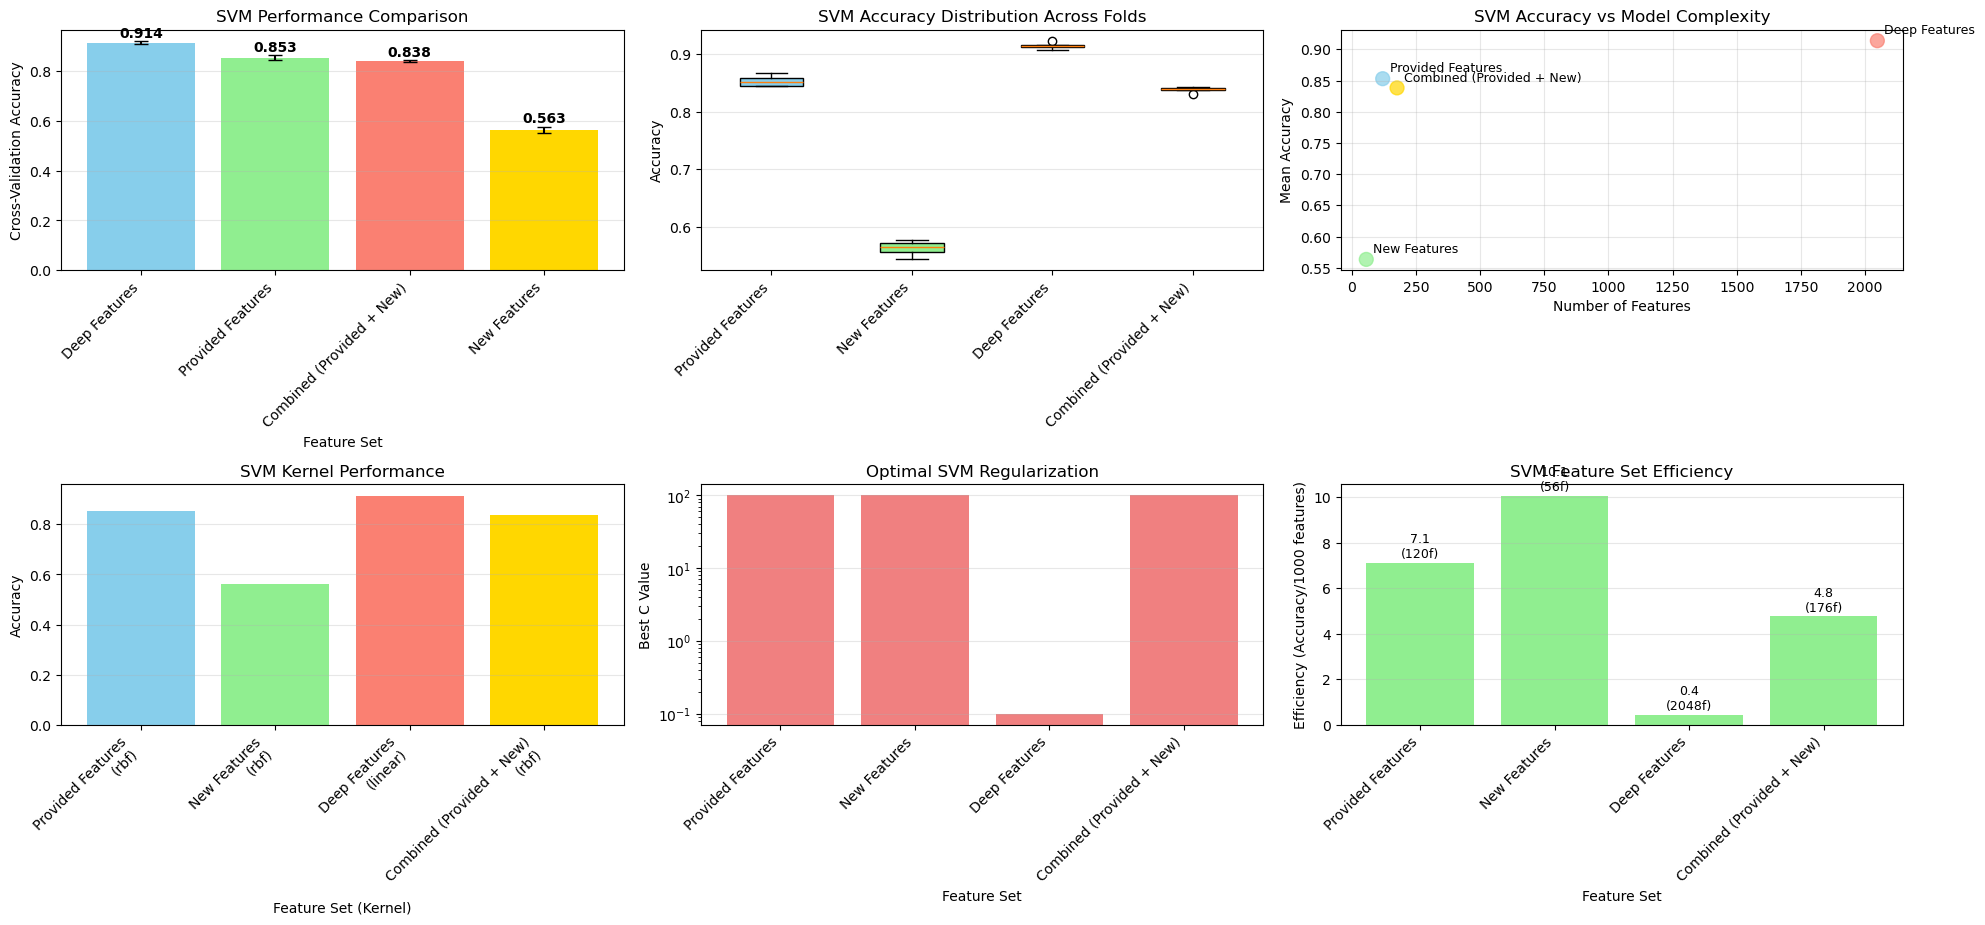

In [12]:
# c=reate visualizations
fig = plt.figure(figsize=(20, 12))

# subplot 1: mean accuracy with error bars
plt.subplot(3, 3, 1)
feature_names = results_df['Feature Set']
means = results_df['Mean Accuracy']
stds = results_df['Std Accuracy']

bars = plt.bar(range(len(feature_names)), means, yerr=stds, capsize=5, 
               color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.xlabel('Feature Set')
plt.ylabel('Cross-Validation Accuracy')
plt.title('SVM Performance Comparison')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.005, f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

# subplot 2: box plot of fold accuracies
plt.subplot(3, 3, 2)
unique_names = list(cv_results.keys())
box_data = [cv_results[name]['fold_accuracies'] for name in unique_names]

bp = plt.boxplot(box_data, labels=unique_names, patch_artist=True)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Accuracy')
plt.title('SVM Accuracy Distribution Across Folds')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Subplot 3: Model complexity comparison
plt.subplot(3, 3, 3)
n_features = [feature_importance_results[name]['n_features'] for name in unique_names]
accuracies = [cv_results[name]['mean_accuracy'] for name in unique_names]

plt.scatter(n_features, accuracies, s=100, c=colors, alpha=0.7)
for i, name in enumerate(unique_names):
    plt.annotate(name, (n_features[i], accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Number of Features')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs Model Complexity')
plt.grid(alpha=0.3)

# subplot 4: Kernel comparison (from best model)
plt.subplot(3, 3, 4)
kernels_used = []
kernel_accuracies = []
for name in unique_names:
    if 'best_params' in cv_results[name]:
        kernel = cv_results[name]['best_params'].get('kernel', 'unknown')
        acc = cv_results[name]['mean_accuracy']
        kernels_used.append(f"{name}\n({kernel})")
        kernel_accuracies.append(acc)

if kernels_used:
    plt.bar(range(len(kernels_used)), kernel_accuracies, color=colors[:len(kernels_used)])
    plt.xlabel('Feature Set (Kernel)')
    plt.ylabel('Accuracy')
    plt.title('SVM Kernel Performance')
    plt.xticks(range(len(kernels_used)), kernels_used, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

# subplot 5: Hyperparameter C values
plt.subplot(3, 3, 5)
c_values = []
c_names = []
for name in unique_names:
    if 'best_params' in cv_results[name]:
        c_val = cv_results[name]['best_params'].get('C', 1)
        c_values.append(c_val)
        c_names.append(name)

if c_values:
    plt.bar(range(len(c_names)), c_values, color='lightcoral')
    plt.xlabel('Feature Set')
    plt.ylabel('Best C Value')
    plt.title('Optimal SVM Regularization')
    plt.xticks(range(len(c_names)), c_names, rotation=45, ha='right')
    plt.yscale('log')
    plt.grid(axis='y', alpha=0.3)

# subplot 6: Feature set efficiency
plt.subplot(3, 3, 6)
efficiency_scores = []
feature_counts = []
for name in unique_names:
    n_feat = feature_importance_results[name]['n_features']
    acc = cv_results[name]['mean_accuracy']
    efficiency = acc / n_feat * 1000  # Accuracy per 1000 features
    efficiency_scores.append(efficiency)
    feature_counts.append(n_feat)

bars = plt.bar(range(len(unique_names)), efficiency_scores, color='lightgreen')
plt.xlabel('Feature Set')
plt.ylabel('Efficiency (Accuracy/1000 features)')
plt.title('SVM Feature Set Efficiency')
plt.xticks(range(len(unique_names)), unique_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# add value labels
for i, (eff, n_feat) in enumerate(zip(efficiency_scores, feature_counts)):
    plt.text(i, eff + 0.1, f'{eff:.1f}\n({n_feat}f)', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('comprehensive_svm_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# detailed analysis
print("\n Detailed Analysis:")
print("-" * 40)

# best performing model
best_model = results_df.iloc[0]
print(f" Best performing feature set: {best_model['Feature Set']}")
print(f"   Mean accuracy: {best_model['Mean Accuracy']:.4f} (±{best_model['Std Accuracy']:.4f})")

# hyperparameter analysis
print(f"\n Best Hyperparameters:")
for name, results in cv_results.items():
    if 'best_params' in results:
        print(f"   {name}: {results['best_params']}")

# performance comparison
print(f"\n Performance ranking:")
for i, row in results_df.iterrows():
    print(f"   {i+1}. {row['Feature Set']}: {row['Mean Accuracy']:.4f}")

# Detailed per-class analysis for best model
best_model_name = results_df.iloc[0]['Feature Set']
best_results = cv_results[best_model_name]

print(f"DETAILED ANALYSIS FOR BEST SVM MODEL: {best_model_name}")

# create class name mapping
class_to_name = dict(zip(train_metadata['ClassId'], train_metadata['SignName']))

# analyze class performance
class_perf_df, category_perf = analyze_svm_class_performance(
    best_model_name, 
    best_results['all_y_true'], 
    best_results['all_y_pred'],
    train_metadata
)

# confusion matrix analysis
cm, confusion_df = create_svm_confusion_analysis(
    best_results['all_y_true'], 
    best_results['all_y_pred'],
    class_to_name,
    best_model_name
)

# feature set sizes and efficiency
print(f"\n Feature set efficiency analysis:")
for name in unique_names:
    n_feat = feature_importance_results[name]['n_features']
    acc = cv_results[name]['mean_accuracy']
    efficiency = acc / n_feat * 1000
    best_params = cv_results[name].get('best_params', 'Default')
    print(f"   {name}: {n_feat} features, {acc:.4f} accuracy (efficiency: {efficiency:.2f})")
    print(f"      Best params: {best_params}")
print(f" Results saved as 'comprehensive_svm_analysis.png'")


 Detailed Analysis:
----------------------------------------
 Best performing feature set: Deep Features
   Mean accuracy: 0.9138 (±0.0051)

 Best Hyperparameters:
   Provided Features: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
   New Features: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
   Deep Features: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
   Combined (Provided + New): {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

 Performance ranking:
   3. Deep Features: 0.9138
   1. Provided Features: 0.8529
   4. Combined (Provided + New): 0.8382
   2. New Features: 0.5634
DETAILED ANALYSIS FOR BEST SVM MODEL: Deep Features

🔍 Detailed Analysis for Deep Features
--------------------------------------------------

 Per-Category Performance:
              Precision  Recall  F1-Score  Support
Category                                          
Other            0.9766  0.9867    0.9816    983.0
Prohibitions     0.9713  0.9494    0.9600    857.0
Mandatory        0.9361  0.8954    0.913

In [14]:
# to do svm test predictions
submission_start_time = time.time()

#load the data
print(" Loading test data...")
test_metadata = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/test_metadata.csv")
test_color_hist = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/Features/color_histogram.csv")
test_hog_pca = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/Features/hog_pca.csv")
test_additional_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/Features/additional_features.csv")
test_deep_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/deep_features.csv")

# combine test provided features
test_provided_features = test_color_hist.merge(test_hog_pca, on='image_path')
test_provided_features = test_provided_features.merge(test_additional_features, on='image_path')

print(f" Test provided features: {test_provided_features.shape}")
print(f" Test deep features: {test_deep_features.shape}")

def create_svm_submission(model_name, X_train, X_test, y_train, best_params, test_metadata_df):
    """train final SVM model and create submission file"""
    
    print(f"\n Creating SVM submission for {model_name}")
    print("-" * 40)
    
    model_start_time = time.time()
    
    # standardize features which is very important
    print("   Standardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # train final SVM model with best hyperparameters
    print(f"   Training final SVM with best params: {best_params}")
    final_svm = SVC(
        class_weight='balanced',
        random_state=RANDOM_SEED,
        **best_params
    )
    
    final_svm.fit(X_train_scaled, y_train)
    
    # make predictions on test set
    print("   Making predictions on test set...")
    test_predictions = final_svm.predict(X_test_scaled)
    
    # create submission DataFrame
    submission_df = pd.DataFrame({
        'id': test_metadata_df['id'],
        'ClassId': test_predictions
    })
    
    # save submission file
    filename = f'svm_submission_{model_name.lower().replace(" ", "_")}.csv'
    submission_df.to_csv(filename, index=False)
    
    model_time = time.time() - model_start_time
    print(f"    {model_name} SVM submission created: {filename}")
    print(f"    Predicted classes: {len(set(test_predictions))} unique classes")
    print(f"     Time: {model_time:.1f}s")
    
    return submission_df, filename

# prepare final training data
train_provided = feature_sets['Provided Features'].copy()
train_deep = feature_sets['Deep Features'].copy()

# get training features and labels
X_train_provided = train_provided.drop(['image_path', 'ClassId'], axis=1)
y_train = train_provided['ClassId'].values
X_train_deep = train_deep.drop(['image_path', 'ClassId'], axis=1)

# get test features
X_test_provided = test_provided_features.drop(['image_path'], axis=1)
X_test_deep = test_deep_features.drop(['image_path'], axis=1)

# get best hyperparameters
provided_best_params = cv_results['Provided Features']['best_params']
deep_best_params = cv_results['Deep Features']['best_params']

print(f"Best SVM hyperparameters:")
print(f"   Provided Features: {provided_best_params}")
print(f"   Deep Features: {deep_best_params}")

# create submissions for both best models
submissions = {}

# create submissions for top 2 performing models
top_2_models = results_df.head(2)

for idx, row in top_2_models.iterrows():
    model_name = row['Feature Set']
    
    if model_name == 'Provided Features':
        submission_df, filename = create_svm_submission(
            model_name, X_train_provided, X_test_provided, y_train, 
            provided_best_params, test_metadata
        )
    elif model_name == 'Deep Features':
        submission_df, filename = create_svm_submission(
            model_name, X_train_deep, X_test_deep, y_train,
            deep_best_params, test_metadata
        )
    
    submissions[model_name] = (submission_df, filename)

 Loading test data...
 Test provided features: (2353, 121)
 Test deep features: (2353, 2049)
Best SVM hyperparameters:
   Provided Features: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
   Deep Features: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

 Creating SVM submission for Deep Features
----------------------------------------
   Standardizing features...
   Training final SVM with best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
   Making predictions on test set...
    Deep Features SVM submission created: svm_submission_deep_features.csv
    Predicted classes: 43 unique classes
     Time: 18.5s

 Creating SVM submission for Provided Features
----------------------------------------
   Standardizing features...
   Training final SVM with best params: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
   Making predictions on test set...
    Provided Features SVM submission created: svm_submission_provided_features.csv
    Predicted classes: 41 unique classes
     Time: